<h1>Preprocessing </h1>

In [27]:
import tensorflow as tf
import cv2
import numpy as np
import os
import sys # for debugging 

In [178]:
# This function preprocesses the image by reading in the image apply grayscale make all the sizes the same and 
def preprocess_image(file_path, img_size):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # Grayscale will even the playing field if we start getting different types of images. If the images color is a factor we can take out grayscale
    
    # Thresholding to remove black background
    _, binary_image = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    brain_mask = (labels == largest_component_label).astype(np.uint8) * 255
    x, y, w, h = cv2.boundingRect(brain_mask)
    img = img[y:y+h, x:x+w]
    
    img = cv2.resize(img, img_size)
    img = img.astype('float')/255.0 # Make the pixels become float and normalize to 0-1 for normalization
    
    return img


target_size =(224, 224)

# This function will pull from the directory and all subdirectory for the image and give it a label to the directory it is in
def load_images_from_directory(directory):
    images = []
    labels = []
    
    # Iterates through all subdirectories
    for subdir in os.listdir(directory):
        label = subdir #Make the subdirectory name be a label
        subdir_path = os.path.join(directory, subdir)

        # Checks if the object it is looking at is a directory and if it is go into the directory and get all the files and preprocess them
        if os.path.isdir(subdir_path):
            for image in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, image)

                image = preprocess_image(file_path, target_size)
            
                # Append to the arrays after preprocessing
                images.append(image)
                labels.append(label)
        

    return np.array(images), np.array(labels)




In [179]:


# Define the directory paths for the training and test datasets
train_dir = "./Alzheimer_s Dataset/train"
test_dir = "./Alzheimer_s Dataset/test"
# single_test_dir = "./Alzheimer_s Dataset/single_test"

# Load images and labels from the training directory
alz_images_train, alz_labels_train = load_images_from_directory(train_dir)

# Load images and labels from the test directory
alz_images_test, alz_labels_test = load_images_from_directory(test_dir)

# alz_single_images_test, alz_single_labels_test = load_images_from_directory(single_test_dir)

# Print information about the training dataset
print("Train")
print('Image shape:', alz_images_train.shape)
print('Labels shape:', alz_labels_train.shape)

# Print information about the test dataset
print("\nTest")
print('Image shape:', alz_images_test.shape)
print('Labels shape:', alz_labels_test.shape)


# The output of the shape follows this
#  (X, X1, X2)
# X is the number of pictures in the array   
# X1 is the number of rows for a single picture (should be 224 since that is the scale)
# X2 is the number of columns in each picture  (should be 224 since that is the scale)
#  *Scale can be change to 207 since that is how the data is processed. 
# 
# When pull out the full array, you see alot of 0 at the start and end and that is because of the black around the brain
# 


Train
Image shape: (5121, 224, 224)
Labels shape: (5121,)

Test
Image shape: (1279, 224, 224)
Labels shape: (1279,)


<h1> Aaron's Algorithm </h1>
CNN GCNN or similar neural networks that can be adjusted in between each other

In [30]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

alz_labels_train_encoded = label_encoder.fit_transform(alz_labels_train)
alz_labels_test_encoded = label_encoder.fit_transform(alz_labels_test)

num_classes = len(label_encoder.classes_)

alz_labels_train_onehot = tf.keras.utils.to_categorical(alz_labels_train_encoded, num_classes)
alz_labels_test_onehot = tf.keras.utils.to_categorical(alz_labels_test_encoded, num_classes)

print("Training labels shape (one-hot encoded):", alz_labels_train_onehot.shape)
print("Testing labels shape (one-hot encoded):", alz_labels_test_onehot.shape)

# print('Image train:', alz_images_train) # for debugging


# 0 = MildDemented
# 1 = ModerateDemented
# 2 = NonDemented
# 3 = VeryMildDemented

Training labels shape (one-hot encoded): (5121, 4)
Testing labels shape (one-hot encoded): (1279, 4)


In [31]:
img_height = target_size[1]
img_width = target_size[0]
num_channels = 1

<h1> CNN </h1>

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal






# Define model architecture with batch normalization
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, num_channels), 
           kernel_regularizer=regularizers.l2(0.1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)
model_cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)



In [74]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_7 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_8 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

In [37]:
#THE BEST
# Learning rate scheduler - Cyclic Learning Rate
def cyclic_lr(epoch, lr_max=0.001, lr_min=0.0001, step_size=8):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = lr_min + (lr_max - lr_min) * np.maximum(0, (1 - x))
    return lr


lr_scheduler_cyclic_lr = LearningRateScheduler(cyclic_lr)
history_cyclic_lr = model_cnn.fit(alz_images_train, alz_labels_train_onehot, epochs=30, batch_size=32,
                              validation_data=(alz_images_test, alz_labels_test_onehot), 
                              callbacks=[lr_scheduler_cyclic_lr, early_stopping])

Epoch 1/30
161/161 [==============================] - 101s 625ms/step - loss: 2.5363 - accuracy: 0.9344 - val_loss: 4.8531 - val_accuracy: 0.4120 - lr: 1.0000e-04
Epoch 2/30
161/161 [==============================] - 99s 614ms/step - loss: 2.3225 - accuracy: 0.9391 - val_loss: 4.5191 - val_accuracy: 0.2666 - lr: 1.0000e-04
Epoch 3/30
161/161 [==============================] - 100s 619ms/step - loss: 2.1036 - accuracy: 0.9418 - val_loss: 3.8345 - val_accuracy: 0.6364 - lr: 1.0000e-04
Epoch 4/30
161/161 [==============================] - 99s 616ms/step - loss: 1.9403 - accuracy: 0.9442 - val_loss: 3.2050 - val_accuracy: 0.6255 - lr: 1.0000e-04
Epoch 5/30
161/161 [==============================] - 100s 618ms/step - loss: 1.8041 - accuracy: 0.9494 - val_loss: 2.7787 - val_accuracy: 0.6411 - lr: 1.0000e-04
Epoch 6/30
161/161 [==============================] - 99s 618ms/step - loss: 1.6305 - accuracy: 0.9596 - val_loss: 4.3862 - val_accuracy: 0.5794 - lr: 1.0000e-04
Epoch 7/30
161/161 [=====

In [39]:
# THE 2ND BEST
# Learning rate scheduler - Exponential Decay
def exponential_decay(epoch, initial_lr=0.001, decay_rate=0.9):
    return initial_lr * np.power(decay_rate, epoch)


lr_scheduler_exp_decay = LearningRateScheduler(exponential_decay)
history_exp_decay = model_cnn.fit(alz_images_train, alz_labels_train_onehot, epochs=30, batch_size=32,
                              validation_data=(alz_images_test, alz_labels_test_onehot), 
                              callbacks=[lr_scheduler_exp_decay, early_stopping])

Epoch 1/30
161/161 [==============================] - 101s 624ms/step - loss: 1.1259 - accuracy: 0.9707 - val_loss: 2.1985 - val_accuracy: 0.6716 - lr: 1.0000e-04
Epoch 2/30
161/161 [==============================] - 100s 620ms/step - loss: 0.9004 - accuracy: 0.9848 - val_loss: 1.9960 - val_accuracy: 0.6552 - lr: 9.0000e-05
Epoch 3/30
161/161 [==============================] - 101s 629ms/step - loss: 0.8102 - accuracy: 0.9844 - val_loss: 3.0506 - val_accuracy: 0.5528 - lr: 7.2900e-05
Epoch 4/30
161/161 [==============================] - 100s 622ms/step - loss: 0.6384 - accuracy: 0.9934 - val_loss: 1.7810 - val_accuracy: 0.6622 - lr: 5.3144e-05
Epoch 5/30
161/161 [==============================] - 100s 623ms/step - loss: 0.5219 - accuracy: 0.9990 - val_loss: 1.3900 - val_accuracy: 0.7076 - lr: 3.4868e-05
Epoch 6/30
161/161 [==============================] - 101s 626ms/step - loss: 0.4360 - accuracy: 0.9996 - val_loss: 1.3769 - val_accuracy: 0.7099 - lr: 2.0589e-05
Epoch 7/30
161/161 [==

In [134]:
# Evaluate the model on the test data
from sklearn.metrics import classification_report


test_loss, test_accuracy = model_cnn.evaluate(alz_images_test, alz_labels_test_onehot)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict the test labels
y_pred = model_cnn.predict(alz_images_test)

# Get the categorical names
categorical_names = label_encoder.inverse_transform(np.arange(num_classes))

# Convert predicted labels from one-hot encoded format to categorical names
y_pred_categorical_names = categorical_names[np.argmax(y_pred, axis=1)]
test_labels_categorical_names = categorical_names[np.argmax(alz_labels_test_onehot, axis=1)]

# Generate classification report
report = classification_report(test_labels_categorical_names, y_pred_categorical_names)
print(report)

40/40 [==============================] - 5s 133ms/step - loss: 1.3506 - accuracy: 0.7209
Test Loss: 1.3505847454071045
Test Accuracy: 0.7208756804466248
40/40 [==============================] - 5s 126ms/step
                  precision    recall  f1-score   support

    MildDemented       0.69      0.45      0.55       179
ModerateDemented       1.00      0.33      0.50        12
     NonDemented       0.77      0.81      0.79       640
VeryMildDemented       0.66      0.71      0.68       448

        accuracy                           0.72      1279
       macro avg       0.78      0.58      0.63      1279
    weighted avg       0.72      0.72      0.72      1279



In [135]:
report_dict_cnn = classification_report(test_labels_categorical_names, y_pred_categorical_names, output_dict=True)

cnn_dict = {
    "accuracy": test_accuracy,
    "MildDemented": {
        "precision": report_dict_cnn["MildDemented"]["precision"],
        "recall": report_dict_cnn["MildDemented"]["recall"],
        "f1-score": report_dict_cnn["MildDemented"]["f1-score"]
    },
    "ModerateDemented": {
        "precision": report_dict_cnn["ModerateDemented"]["precision"],
        "recall": report_dict_cnn["ModerateDemented"]["recall"],
        "f1-score": report_dict_cnn["ModerateDemented"]["f1-score"]
    },
    "NonDemented": {
        "precision": report_dict_cnn["NonDemented"]["precision"],
        "recall": report_dict_cnn["NonDemented"]["recall"],
        "f1-score": report_dict_cnn["NonDemented"]["f1-score"]
    },
    "VeryMildDemented": {
        "precision": report_dict_cnn["VeryMildDemented"]["precision"],
        "recall": report_dict_cnn["VeryMildDemented"]["recall"],
        "f1-score": report_dict_cnn["VeryMildDemented"]["f1-score"]
    }
}

print(cnn_dict)

{'accuracy': 0.7208756804466248, 'MildDemented': {'precision': 0.6864406779661016, 'recall': 0.45251396648044695, 'f1-score': 0.5454545454545455}, 'ModerateDemented': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5}, 'NonDemented': {'precision': 0.7695716395864106, 'recall': 0.8140625, 'f1-score': 0.7911921032649962}, 'VeryMildDemented': {'precision': 0.6583333333333333, 'recall': 0.7053571428571429, 'f1-score': 0.6810344827586208}}


<h1> DNN </h1>

In [44]:
# Reshape the input data to have rank 4
alz_images_train_dnn = alz_images_train.reshape(-1, 224, 224, 1)
alz_images_test_dnn = alz_images_test.reshape(-1, 224, 224, 1)

# Verify the shapes
print("Training data shape:", alz_images_train.shape)
print("Testing data shape:", alz_images_test.shape)


Training data shape: (5121, 224, 224)
Testing data shape: (1279, 224, 224)


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define model architecture with batch normalization
model_deep = Sequential([
    Flatten(input_shape=(img_height, img_width, num_channels)),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)
model_deep.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def exponential_decay(epoch, initial_lr=0.001, decay_rate=0.9):
    return initial_lr * np.power(decay_rate, epoch)

lr_scheduler_exp_decay = LearningRateScheduler(exponential_decay)


# Create an instance of ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the height
    shear_range=0.2,        # Randomly apply shear transformations
    zoom_range=0.2,         # Randomly zoom in by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in newly created pixels (due to augmentation) using the nearest existing pixel
)


# Define batch size and number of epochs
batch_size = 32
epochs = 30

# Create augmented training data generator
train_generator = datagen.flow(alz_images_train_dnn, alz_labels_train_onehot, batch_size=batch_size)



# Train the model using the augmented data generator
history = model_deep.fit(train_generator,
                    steps_per_epoch=len(alz_images_train) // batch_size,
                    epochs=epochs,
                    validation_data=(alz_images_test_dnn, alz_labels_test_onehot),
                    callbacks=[early_stopping, lr_scheduler_exp_decay])



Epoch 1/30
160/160 [==============================] - 26s 160ms/step - loss: 9.3799 - accuracy: 0.4380 - val_loss: 4.7280 - val_accuracy: 0.1431 - lr: 0.0010
Epoch 2/30
160/160 [==============================] - 26s 161ms/step - loss: 3.0621 - accuracy: 0.4746 - val_loss: 2.3759 - val_accuracy: 0.4980 - lr: 9.0000e-04
Epoch 3/30
160/160 [==============================] - 26s 160ms/step - loss: 2.0157 - accuracy: 0.5030 - val_loss: 1.7878 - val_accuracy: 0.4934 - lr: 7.2900e-04
Epoch 4/30
160/160 [==============================] - 26s 161ms/step - loss: 1.5979 - accuracy: 0.4993 - val_loss: 1.5310 - val_accuracy: 0.5270 - lr: 5.3144e-04
Epoch 5/30
160/160 [==============================] - 26s 159ms/step - loss: 1.4079 - accuracy: 0.4972 - val_loss: 1.4971 - val_accuracy: 0.4762 - lr: 3.4868e-04
Epoch 6/30
160/160 [==============================] - 26s 160ms/step - loss: 1.2948 - accuracy: 0.5048 - val_loss: 1.2413 - val_accuracy: 0.5192 - lr: 2.0589e-04
Epoch 7/30
160/160 [============

In [136]:
# Evaluate the model on the test data
from sklearn.metrics import classification_report


test_loss, test_accuracy = model_deep.evaluate(alz_images_test_dnn, alz_labels_test_onehot)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict the test labels
y_pred = model_deep.predict(alz_images_test_dnn)

# Get the categorical names
categorical_names = label_encoder.inverse_transform(np.arange(num_classes))

# Convert predicted labels from one-hot encoded format to categorical names
y_pred_categorical_names = categorical_names[np.argmax(y_pred, axis=1)]
test_labels_categorical_names = categorical_names[np.argmax(alz_labels_test_onehot, axis=1)]

# Generate classification report
report = classification_report(test_labels_categorical_names, y_pred_categorical_names)
print(report)

40/40 [==============================] - 1s 14ms/step - loss: 1.3243 - accuracy: 0.5199
Test Loss: 1.324284553527832
Test Accuracy: 0.5199374556541443
40/40 [==============================] - 0s 11ms/step
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.52      0.98      0.68       640
VeryMildDemented       0.47      0.08      0.14       448

        accuracy                           0.52      1279
       macro avg       0.25      0.27      0.21      1279
    weighted avg       0.43      0.52      0.39      1279



c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [137]:
report_dict_dnn = classification_report(test_labels_categorical_names, y_pred_categorical_names, output_dict=True)

dnn_dict = {
    "accuracy": test_accuracy,
    "MildDemented": {
        "precision": report_dict_dnn["MildDemented"]["precision"],
        "recall": report_dict_dnn["MildDemented"]["recall"],
        "f1-score": report_dict_dnn["MildDemented"]["f1-score"]
    },
    "ModerateDemented": {
        "precision": report_dict_dnn["ModerateDemented"]["precision"],
        "recall": report_dict_dnn["ModerateDemented"]["recall"],
        "f1-score": report_dict_dnn["ModerateDemented"]["f1-score"]
    },
    "NonDemented": {
        "precision": report_dict_dnn["NonDemented"]["precision"],
        "recall": report_dict_dnn["NonDemented"]["recall"],
        "f1-score": report_dict_dnn["NonDemented"]["f1-score"]
    },
    "VeryMildDemented": {
        "precision": report_dict_dnn["VeryMildDemented"]["precision"],
        "recall": report_dict_dnn["VeryMildDemented"]["recall"],
        "f1-score": report_dict_dnn["VeryMildDemented"]["f1-score"]
    }
}

print(dnn_dict)

{'accuracy': 0.5199374556541443, 'MildDemented': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'ModerateDemented': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'NonDemented': {'precision': 0.5229357798165137, 'recall': 0.9796875, 'f1-score': 0.6818923327895595}, 'VeryMildDemented': {'precision': 0.475, 'recall': 0.08482142857142858, 'f1-score': 0.14393939393939395}}


c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
from imblearn.over_sampling import RandomOverSampler

# Create the oversampler
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling to your training data
alz_train_balanced_mod, alz_train_balanced_label_mod = oversampler.fit_resample(alz_images_train_dnn.reshape(-1, img_height * img_width * num_channels), alz_labels_train_encoded)

# Convert labels back to one-hot encoded format
alz_train_balanced_onehot = tf.keras.utils.to_categorical(alz_train_balanced_label_mod, num_classes)

# Create augmented training data generator
train_generator = datagen.flow(alz_train_balanced_mod.reshape(-1, img_height, img_width, num_channels), alz_train_balanced_onehot, batch_size=batch_size)

# Train the model using the augmented data generator
history = model_deep.fit(train_generator,
                    steps_per_epoch=len(alz_train_balanced_mod) // batch_size,
                    epochs=epochs,
                    validation_data=(alz_images_test_dnn, alz_labels_test_onehot),
                    callbacks=[early_stopping, lr_scheduler_exp_decay])



Epoch 1/30
320/320 [==============================] - 51s 158ms/step - loss: 2.1901 - accuracy: 0.2996 - val_loss: 1.3435 - val_accuracy: 0.5168 - lr: 3.0433e-06
Epoch 2/30
320/320 [==============================] - 50s 157ms/step - loss: 2.0955 - accuracy: 0.3040 - val_loss: 1.3299 - val_accuracy: 0.5192 - lr: 2.7389e-06
Epoch 3/30
320/320 [==============================] - 50s 157ms/step - loss: 2.0311 - accuracy: 0.3116 - val_loss: 1.3243 - val_accuracy: 0.5199 - lr: 2.2185e-06
Epoch 4/30
320/320 [==============================] - 51s 158ms/step - loss: 1.9750 - accuracy: 0.3133 - val_loss: 1.3641 - val_accuracy: 0.5215 - lr: 1.6173e-06
Epoch 5/30
320/320 [==============================] - 51s 159ms/step - loss: 1.9418 - accuracy: 0.3226 - val_loss: 1.3792 - val_accuracy: 0.5199 - lr: 1.0611e-06
Epoch 6/30
320/320 [==============================] - 50s 157ms/step - loss: 1.9186 - accuracy: 0.3261 - val_loss: 1.3939 - val_accuracy: 0.5129 - lr: 6.2658e-07


<h1>CNN with Graph based features</h1>


In [48]:
from sklearn.decomposition import PCA

# Generator function to yield batches of preprocessed images
def image_generator(images, batch_size=32):
    num_images = len(images)
    num_batches = (num_images + batch_size - 1) // batch_size
    
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, num_images)
        
        # Load and preprocess images for the current batch
        batch_images = np.stack((images[start_index:end_index],) * 3, axis=-1)
        preprocessed_images = tf.keras.applications.mobilenet_v2.preprocess_input(batch_images)
        
        yield preprocessed_images

# Function to extract features from images using a pre-trained CNN and perform PCA
def extract_features(images, batch_size=32, n_components=64):
    feature_extractor = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    feature_extractor.trainable = False
    
    features = []
    for batch_images in image_generator(images, batch_size=batch_size):
        batch_features = feature_extractor.predict(batch_images)
        batch_features_flat = batch_features.reshape(batch_features.shape[0], -1)
        features.append(batch_features_flat)
    
    all_features = np.concatenate(features, axis=0)
    
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(all_features)
    
    return reduced_features

# Extract features from training and test images
train_features = extract_features(alz_images_train)
test_features = extract_features(alz_images_test)

1/1 [==============================] - 1s 706ms/step


In [49]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Compute adjacency matrix based on feature similarity
def compute_feature_similarity(features):
    num_images = features.shape[0]
    similarities = np.zeros((num_images, num_images))
    for i in range(num_images):
        for j in range(num_images):
            # Compute cosine similarity between feature vectors
            similarities[i, j] = cosine_similarity(features[i].reshape(1, -1), features[j].reshape(1, -1))[0, 0]
    return similarities

In [50]:
# Compute feature similarities for training and test images
train_feature_similarity = compute_feature_similarity(train_features)

In [51]:
test_feature_similarity = compute_feature_similarity(test_features)

In [52]:
similarity_threshold = 0.8

# Construct adjacency matrix based on feature similarity
def construct_adjacency_matrix(feature_similarity, threshold):
    num_images = feature_similarity.shape[0]
    adjacency_matrix = np.zeros((num_images, num_images))
    for i in range(num_images):
        for j in range(num_images):
            # Set adjacency matrix value based on whether feature similarity is above threshold
            if feature_similarity[i, j] >= threshold:
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1  # Symmetric adjacency matrix
    return adjacency_matrix


In [53]:
# Compute adjacency matrix for training and test images
train_adj_matrix = construct_adjacency_matrix(train_feature_similarity, similarity_threshold)
print("Shape of adjacency matrix for training images:", train_adj_matrix.shape)

Shape of adjacency matrix for training images: (5121, 5121)


In [54]:
test_adj_matrix = construct_adjacency_matrix(test_feature_similarity, similarity_threshold)
print("Shape of adjacency matrix for test images:", test_adj_matrix.shape)

Shape of adjacency matrix for test images: (1279, 1279)


In [55]:
print("Shape of train_features:", train_features.shape)
print("Shape of test_features:", test_features.shape)

print("\nShape of train_features similarity:", train_feature_similarity.shape)
print("Shape of test_features similarity:", test_feature_similarity.shape)

print("\nShape of train_adj_matrix:", train_adj_matrix.shape)
print("Shape of test_adj_matrix:", test_adj_matrix.shape)


Shape of train_features: (5121, 64)
Shape of test_features: (1279, 64)

Shape of train_features similarity: (5121, 5121)
Shape of test_features similarity: (1279, 1279)

Shape of train_adj_matrix: (5121, 5121)
Shape of test_adj_matrix: (1279, 1279)


In [56]:
# Images with grayscale index
alz_images_train_with_grayscale_index = alz_images_train[..., np.newaxis]  # Add channel dimension for grayscale images
alz_images_test_with_grayscale_index = alz_images_test[..., np.newaxis]

# Integrate graph-based features
train_features_with_graph = np.concatenate([train_features, train_adj_matrix], axis=1)
test_features_with_graph = np.concatenate([test_features, test_adj_matrix], axis=1)

print("Shape of training images with grayscale index:", alz_images_train_with_grayscale_index.shape)
print("Shape of testing images with grayscale index:", alz_images_test_with_grayscale_index.shape)
print("Shape of training features with graph:", train_features_with_graph.shape)
print("Shape of testing features with graph:", test_features_with_graph.shape)

Shape of training images with grayscale index: (5121, 224, 224, 1)
Shape of testing images with grayscale index: (1279, 224, 224, 1)
Shape of training features with graph: (5121, 5185)
Shape of testing features with graph: (1279, 1343)


In [57]:
import numpy as np

# Pad the test adjacency matrix with zeros to match the shape of the train adjacency matrix
max_nodes = train_adj_matrix.shape[1]
test_adj_matrix_padded = np.pad(test_adj_matrix, ((0, 0), (0, max_nodes - test_adj_matrix.shape[1])), mode='constant')

# Verify the shape of the padded test adjacency matrix
print("Shape of padded test_adj_matrix:", test_adj_matrix_padded.shape)

Shape of padded test_adj_matrix: (1279, 5121)


In [91]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

# Define input layers for image data and graph data
image_input = Input(shape=(img_height, img_width, 1), name='image_input')
graph_input = Input(shape=(train_features.shape[1],), name='graph_input')
adj_input = Input(shape=(train_adj_matrix.shape[1],), name='adj_input')

# Flatten the image data
conv1 = Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, num_channels), 
           kernel_regularizer=regularizers.l2(0.1))(image_input)
conv1_bn = BatchNormalization()(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1_bn)


conv2 = Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.1))(maxpool1)
conv2_bn = BatchNormalization()(conv2)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2_bn)

conv3 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1))(maxpool2)
conv3_bn = BatchNormalization()(conv3)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(conv3_bn)


flatten_image = Flatten()(maxpool3)

# Concatenate flattened image data with graph data and adjacency matrix
concatenated_input = Concatenate()([flatten_image, graph_input, adj_input])

# Define the dense layers with dropout regularization
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated_input)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

# Output layer
output = Dense(4, activation='softmax', name='output')(x)

# Create the model
model_complex_most_complex = Model(inputs=[image_input, graph_input, adj_input], outputs=output)

# Compile the model
model_complex_most_complex.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


def cyclic_lr(epoch, lr_max=0.001, lr_min=0.0001, step_size=8):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = lr_min + (lr_max - lr_min) * np.maximum(0, (1 - x))
    return lr

lr_scheduler_cyclic_lr = LearningRateScheduler(cyclic_lr)

In [92]:
model_complex_most_complex.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 222, 222, 32  320         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 222, 222, 32  128        ['conv2d_12[0][0]']              
 ormalization)                  )                                                          

In [93]:
history3 = model_complex_most_complex.fit(
    {'image_input': alz_images_train_with_grayscale_index, 'graph_input': train_features, 'adj_input': train_adj_matrix},
    {'output': alz_labels_train_onehot},
    epochs=30,
    batch_size=32,
    validation_data=({'image_input': alz_images_test_with_grayscale_index, 'graph_input': test_features, 'adj_input': test_adj_matrix_padded}, {'output': alz_labels_test_onehot}),
    callbacks=[lr_scheduler_cyclic_lr, early_stopping]
)

Epoch 1/30
161/161 [==============================] - 102s 629ms/step - loss: 22.8442 - accuracy: 0.4958 - val_loss: 38.4964 - val_accuracy: 0.0094 - lr: 1.0000e-04
Epoch 2/30
161/161 [==============================] - 100s 619ms/step - loss: 15.9208 - accuracy: 0.5384 - val_loss: 22.1348 - val_accuracy: 0.0962 - lr: 1.0000e-04
Epoch 3/30
161/161 [==============================] - 97s 606ms/step - loss: 11.3933 - accuracy: 0.6085 - val_loss: 10.8859 - val_accuracy: 0.5278 - lr: 1.0000e-04
Epoch 4/30
161/161 [==============================] - 98s 609ms/step - loss: 8.2242 - accuracy: 0.6735 - val_loss: 7.7258 - val_accuracy: 0.5066 - lr: 1.0000e-04
Epoch 5/30
161/161 [==============================] - 99s 614ms/step - loss: 6.0936 - accuracy: 0.7192 - val_loss: 5.8405 - val_accuracy: 0.5301 - lr: 1.0000e-04
Epoch 6/30
161/161 [==============================] - 98s 610ms/step - loss: 4.5949 - accuracy: 0.7778 - val_loss: 4.5788 - val_accuracy: 0.5903 - lr: 1.0000e-04
Epoch 7/30
161/161 [

In [138]:
from sklearn.metrics import classification_report

test_loss, test_accuracy = model_complex_most_complex.evaluate(
    {'image_input': alz_images_test_with_grayscale_index, 'graph_input': test_features, 'adj_input': test_adj_matrix_padded},
    {'output': alz_labels_test_onehot}
)

# Predict the test labels
y_pred = model_complex_most_complex.predict(
    {'image_input': alz_images_test_with_grayscale_index, 'graph_input': test_features, 'adj_input': test_adj_matrix_padded}
)


# Get the categorical names
categorical_names = label_encoder.inverse_transform(np.arange(num_classes))

# Convert predicted labels from one-hot encoded format to categorical names
y_pred_categorical_names = categorical_names[np.argmax(y_pred, axis=1)]
test_labels_categorical_names = categorical_names[np.argmax(alz_labels_test_onehot, axis=1)]

# Generate classification report
report = classification_report(test_labels_categorical_names, y_pred_categorical_names)
print(report)

40/40 [==============================] - 4s 104ms/step
                  precision    recall  f1-score   support

    MildDemented       0.51      0.39      0.44       179
ModerateDemented       1.00      0.25      0.40        12
     NonDemented       0.65      0.91      0.76       640
VeryMildDemented       0.70      0.38      0.50       448

        accuracy                           0.65      1279
       macro avg       0.72      0.48      0.52      1279
    weighted avg       0.65      0.65      0.62      1279



In [139]:
report_dict_cnn_graph = classification_report(test_labels_categorical_names, y_pred_categorical_names, output_dict=True)

cnn_graph_dict = {
    "accuracy": test_accuracy,
    "MildDemented": {
        "precision": report_dict_cnn_graph["MildDemented"]["precision"],
        "recall": report_dict_cnn_graph["MildDemented"]["recall"],
        "f1-score": report_dict_cnn_graph["MildDemented"]["f1-score"]
    },                          
    "ModerateDemented": {
        "precision": report_dict_cnn_graph["ModerateDemented"]["precision"],
        "recall": report_dict_cnn_graph["ModerateDemented"]["recall"],
        "f1-score": report_dict_cnn_graph["ModerateDemented"]["f1-score"]
    },
    "NonDemented": {
        "precision": report_dict_cnn_graph["NonDemented"]["precision"],
        "recall": report_dict_cnn_graph["NonDemented"]["recall"],
        "f1-score": report_dict_cnn_graph["NonDemented"]["f1-score"]
    },
    "VeryMildDemented": {
        "precision": report_dict_cnn_graph["VeryMildDemented"]["precision"],
        "recall": report_dict_cnn_graph["VeryMildDemented"]["recall"],
        "f1-score": report_dict_cnn_graph["VeryMildDemented"]["f1-score"]
    }
}

print(cnn_graph_dict)

{'accuracy': 0.6450352072715759, 'MildDemented': {'precision': 0.5073529411764706, 'recall': 0.3854748603351955, 'f1-score': 0.43809523809523804}, 'ModerateDemented': {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4}, 'NonDemented': {'precision': 0.6484375, 'recall': 0.9078125, 'f1-score': 0.7565104166666667}, 'VeryMildDemented': {'precision': 0.7049180327868853, 'recall': 0.38392857142857145, 'f1-score': 0.4971098265895954}}


<h1>Jay's Algorthm</h1>
SVM and KNN (K-Nearest Neighbors)

Test Accuracy: 0.73
                  precision    recall  f1-score   support

    MildDemented       0.64      0.59      0.61       179
ModerateDemented       0.50      0.58      0.54        12
     NonDemented       0.79      0.81      0.80       640
VeryMildDemented       0.69      0.68      0.68       448

        accuracy                           0.73      1279
       macro avg       0.66      0.67      0.66      1279
    weighted avg       0.73      0.73      0.73      1279

Accuracy for k=1: 0.75
Accuracy for k=2: 0.73
Accuracy for k=3: 0.73
Accuracy for k=4: 0.72
Accuracy for k=5: 0.70
Accuracy for k=6: 0.67
Accuracy for k=7: 0.66
Accuracy for k=8: 0.65
Accuracy for k=9: 0.63
Accuracy for k=10: 0.61
Accuracy for k=11: 0.62
Accuracy for k=12: 0.60
Accuracy for k=13: 0.61
Accuracy for k=14: 0.60


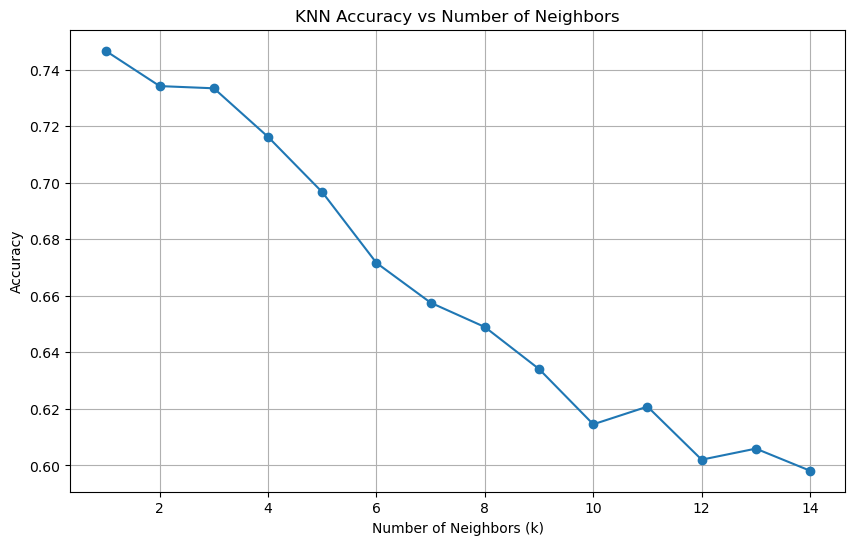

                  precision    recall  f1-score   support

    MildDemented       0.81      0.12      0.20       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.61      0.86      0.72       640
VeryMildDemented       0.54      0.43      0.48       448

        accuracy                           0.60      1279
       macro avg       0.49      0.35      0.35      1279
    weighted avg       0.61      0.60      0.56      1279



c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [146]:
#KNN
import tensorflow as tf
import cv2
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

# Load and preprocess the images
train_dir = "./Alzheimer_s Dataset/train"
test_dir = "./Alzheimer_s Dataset/test"

alz_images_train, alz_labels_train = load_images_from_directory(train_dir)
alz_images_test, alz_labels_test = load_images_from_directory(test_dir)

# Flatten image data for KNN compatability
alz_images_train_flat = flatten_images(alz_images_train)
alz_images_test_flat = flatten_images(alz_images_test)

# Initialize KNN model
knn = KNeighborsClassifier(n_neighbors=3)  # You can tune the number of neighbors here

# Fit KNN model on the training data
knn.fit(alz_images_train_flat, alz_labels_train)

# KNN model on test data
alz_labels_pred = knn.predict(alz_images_test_flat)

# accuracy score
accuracy = accuracy_score(alz_labels_test, alz_labels_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Classification report
from sklearn.metrics import classification_report
print(classification_report(alz_labels_test, alz_labels_pred))
report_dict_knn = classification_report(alz_labels_test, alz_labels_pred, output_dict=True)

# Initialize lists to store accuracies and k values
k_values = list(range(1, 15))  # Evaluating k from 1 to 14
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(alz_images_train_flat, alz_labels_train)
    alz_labels_pred = knn.predict(alz_images_test_flat)
    accuracy = accuracy_score(alz_labels_test, alz_labels_pred)
    accuracies.append(accuracy)
    print(f"Accuracy for k={k}: {accuracy:.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print(classification_report(alz_labels_test, alz_labels_pred))
#

In [147]:
# Generate classification report

print(report_dict_knn)


{'MildDemented': {'precision': 0.6402439024390244, 'recall': 0.5865921787709497, 'f1-score': 0.6122448979591837, 'support': 179}, 'ModerateDemented': {'precision': 0.5, 'recall': 0.5833333333333334, 'f1-score': 0.5384615384615384, 'support': 12}, 'NonDemented': {'precision': 0.7929984779299848, 'recall': 0.8140625, 'f1-score': 0.8033924441017735, 'support': 640}, 'VeryMildDemented': {'precision': 0.6869369369369369, 'recall': 0.6808035714285714, 'f1-score': 0.6838565022421524, 'support': 448}, 'accuracy': 0.7333854573885848, 'macro avg': {'precision': 0.6550448293264866, 'recall': 0.6661978958832135, 'f1-score': 0.6594888456911621, 'support': 1279}, 'weighted avg': {'precision': 0.7317204317119025, 'recall': 0.7333854573885848, 'f1-score': 0.7322847947035588, 'support': 1279}}


In [148]:
knn_dict = {
    "accuracy": report_dict_knn["accuracy"],
    "MildDemented": {
        "precision": report_dict_knn["MildDemented"]["precision"],
        "recall": report_dict_knn["MildDemented"]["recall"],
        "f1-score": report_dict_knn["MildDemented"]["f1-score"]
    },                          
    "ModerateDemented": {
        "precision": report_dict_knn["ModerateDemented"]["precision"],
        "recall": report_dict_knn["ModerateDemented"]["recall"],
        "f1-score": report_dict_knn["ModerateDemented"]["f1-score"]
    },
    "NonDemented": {
        "precision": report_dict_knn["NonDemented"]["precision"],
        "recall": report_dict_knn["NonDemented"]["recall"],
        "f1-score": report_dict_knn["NonDemented"]["f1-score"]
    },
    "VeryMildDemented": {
        "precision": report_dict_knn["VeryMildDemented"]["precision"],
        "recall": report_dict_knn["VeryMildDemented"]["recall"],
        "f1-score": report_dict_knn["VeryMildDemented"]["f1-score"]
    }
}

print(knn_dict)

{'accuracy': 0.7333854573885848, 'MildDemented': {'precision': 0.6402439024390244, 'recall': 0.5865921787709497, 'f1-score': 0.6122448979591837}, 'ModerateDemented': {'precision': 0.5, 'recall': 0.5833333333333334, 'f1-score': 0.5384615384615384}, 'NonDemented': {'precision': 0.7929984779299848, 'recall': 0.8140625, 'f1-score': 0.8033924441017735}, 'VeryMildDemented': {'precision': 0.6869369369369369, 'recall': 0.6808035714285714, 'f1-score': 0.6838565022421524}}


In [150]:
#SVM
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Functions as defined previously

def preprocess_image(file_path, img_size):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = img.astype('float') / 255.0
    return img.flatten()  # Flatten the image

def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    for subdir in os.listdir(directory):
        label = subdir
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for image in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, image)
                image = preprocess_image(file_path, target_size)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load the data
train_dir = "./Alzheimer_s Dataset/train"
test_dir = "./Alzheimer_s Dataset/test"
alz_images_train, alz_labels_train = load_images_from_directory(train_dir)
alz_images_test, alz_labels_test = load_images_from_directory(test_dir)

# Label encoding
label_encoder = LabelEncoder()
alz_labels_train_encoded = label_encoder.fit_transform(alz_labels_train)
alz_labels_test_encoded = label_encoder.transform(alz_labels_test)

# Create SVM model
model = svm.SVC(kernel='linear', C=1.0, random_state=42)  # You can experiment with the kernel and C parameter
model.fit(alz_images_train, alz_labels_train_encoded)

# Prediction
predictions = model.predict(alz_images_test)

# Evaluation
print("Accuracy:", accuracy_score(alz_labels_test_encoded, predictions))
print("Classification Report:")
print(classification_report(alz_labels_test_encoded, predictions, target_names=label_encoder.classes_))

Accuracy: 0.6387802971071149
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.75      0.30      0.42       179
ModerateDemented       1.00      0.33      0.50        12
     NonDemented       0.67      0.80      0.73       640
VeryMildDemented       0.57      0.56      0.56       448

        accuracy                           0.64      1279
       macro avg       0.75      0.50      0.55      1279
    weighted avg       0.65      0.64      0.62      1279



In [155]:
report_dict_svm = classification_report(alz_labels_test_encoded, predictions, output_dict=True)
print(report_dict_svm)

svm_dict = {
    "accuracy": report_dict_svm["accuracy"],
    "MildDemented": {
        "precision": report_dict_svm["0"]["precision"],
        "recall": report_dict_svm["0"]["recall"],
        "f1-score": report_dict_svm["0"]["f1-score"]
    },                          
    "ModerateDemented": {
        "precision": report_dict_svm["1"]["precision"],
        "recall": report_dict_svm["1"]["recall"],
        "f1-score": report_dict_svm["1"]["f1-score"]
    },
    "NonDemented": {
        "precision": report_dict_svm["2"]["precision"],
        "recall": report_dict_svm["2"]["recall"],
        "f1-score": report_dict_svm["2"]["f1-score"]
    },
    "VeryMildDemented": {
        "precision": report_dict_svm["3"]["precision"],
        "recall": report_dict_svm["3"]["recall"],
        "f1-score": report_dict_svm["3"]["f1-score"]
    }
}

print(svm_dict)

{'0': {'precision': 0.7464788732394366, 'recall': 0.29608938547486036, 'f1-score': 0.424, 'support': 179}, '1': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 12}, '2': {'precision': 0.6675392670157068, 'recall': 0.796875, 'f1-score': 0.7264957264957265, 'support': 640}, '3': {'precision': 0.5681818181818182, 'recall': 0.5580357142857143, 'f1-score': 0.5630630630630631, 'support': 448}, 'accuracy': 0.6387802971071149, 'macro avg': {'precision': 0.7455499896092403, 'recall': 0.49608335827347705, 'f1-score': 0.5533896973896975, 'support': 1279}, 'weighted avg': {'precision': 0.6469040686046647, 'recall': 0.6387802971071149, 'f1-score': 0.6247893019620933, 'support': 1279}}
{'accuracy': 0.6387802971071149, 'MildDemented': {'precision': 0.7464788732394366, 'recall': 0.29608938547486036, 'f1-score': 0.424}, 'ModerateDemented': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5}, 'NonDemented': {'precision': 0.6675392670157068, 'recall': 0.796875, 

<h1>Geoffrey's Algorithm</h1>
Random Forest and RNN

In [63]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import time
from datetime import timedelta
from sklearn import metrics
import joblib
from sklearn.utils import class_weight
from sklearn.metrics import classification_report


In [64]:
#Since dataset is imbalanced, class_weight parameter will be used for both RFC and RNN

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(alz_labels_train), 
                                     y = alz_labels_train)

class_weights = dict(zip(np.unique(alz_labels_train), class_weights))
class_weights

{'MildDemented': 1.7855648535564854,
 'ModerateDemented': 24.620192307692307,
 'NonDemented': 0.50009765625,
 'VeryMildDemented': 0.7144252232142857}

**G.1: Random Forest Classifier**

Define function to evaluate the performance of an RFC. In summary, it does:
>(1) create and instance of the classifier, <br>
>(2) fit the input training data with the input training label,  <br>
>(3) predict the labels of the input test data, <br>
>(4) compare the predicted and the input test labels, and measure the accuracy <br>
>(5) return both accuracy and elapsed time of the function.

In [157]:
def RFC_evaluate(train =[], train_label= [], 
               test=[], test_label = [],
               n_estimators=[1000], max_depth=[15],
               use_cw = False):
    
    #no of unique parameter combinations
    num_param = len(np.array(n_estimators))*len(np.array(max_depth))
    
    #initialize summary table
    summary = pd.DataFrame(columns=['Estimators', 'Max Depth', 'Training Time', 'Training Accuracy', 'Val Accuracy'])
    
    #evaluate RFC's performance at different parameter value combination
    est_idx = 0
    depth_idx = 0
    
    val_acc_highest = 0.
    curr_val_acc = 0.
    
    for i in range(0, num_param):
        #debug
        #print("i, est_idx, depth_idx: ", i, est_idx, depth_idx)
        
        #record start time for peformance evaluation
        start_time = time.monotonic()

        #create classifier using input parameters
        if(use_cw): rf_classifier = RandomForestClassifier(n_estimators=n_estimators[est_idx], max_depth=max_depth[depth_idx], class_weight = class_weights)
        else:rf_classifier = RandomForestClassifier(n_estimators=n_estimators[est_idx], max_depth=max_depth[depth_idx])
        #fit classifier using input training data and label
        rf_classifier.fit(train, train_label)
        
        #elapsed Time for training
        end_time = time.monotonic()
        elapsedT = timedelta(seconds=end_time - start_time)
        
        #populate accuracy table
        summary.at[i, 'Estimators'] = n_estimators[est_idx]
        summary.at[i, 'Max Depth'] = max_depth[depth_idx]
        summary.at[i, 'Training Time'] = str(elapsedT)
        summary.at[i, 'Training Accuracy'] = metrics.accuracy_score(train_label, rf_classifier.predict(train))
        
        curr_val_acc = metrics.accuracy_score(test_label, rf_classifier.predict(test))
        summary.at[i, 'Val Accuracy'] = curr_val_acc
        
        #save model if current validation accuracy is higher than current highest
        if(curr_val_acc > val_acc_highest):
            val_acc_highest = curr_val_acc
            joblib.dump(rf_classifier, RFCfilepath)
        
        
        #update parameter indexes
        if(depth_idx == len(np.array(max_depth)) - 1 ) : est_idx = est_idx + 1
        depth_idx = (depth_idx + 1)%len(np.array(max_depth)) #always increment by 1 per iteration
        
    return summary

In [158]:
#create RFC folder to save best model into
folder = './Model_Checkpoints/RFC/'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

RFCfilepath = os.path.join(folder, 'Best_RFC_val_acc.joblib')


In [159]:
def equalizeImage(input_images=[]):
    images_eq = []
    for i in range(0, len(input_images)):
        image = np.array(input_images[i]*255).astype(np.uint8)
        image = cv2.equalizeHist(image) 
        images_eq.append(image)
    
    return images_eq


In [160]:
def flattenImage(input_images = []):
    images_flat = []
    for i in range(0, len(input_images)):
        images_flat.append(np.ravel(input_images[i]))
    
    return images_flat

**G.1.1 RFC performance using the pre-processed images as is.**

Note: "as is" meaning NO 'other' feature extraction is done on the images. Each image (size 224x224) will be flattened to a vector of size (50176,) with all the values retained. (as in Module 6 assignment)

In [162]:
#Flatten images, fit, evaluate
flat_train = flattenImage(alz_images_train)

flat_test = flattenImage(alz_images_test)


#Evaluate RFC performance using the following RFC hyperparameters
n_estimators = [500, 1000, 1500]
max_depth = [15, 20, 25]


summary = RFC_evaluate(train = flat_train, train_label = alz_labels_train,
                              test = flat_test, test_label = alz_labels_test,
                              n_estimators = n_estimators, max_depth = max_depth)

summary

,Estimators,Max Depth,Training Time,Training Accuracy,Val Accuracy
0,500,15,0:02:39.438000,1.0,0.652854
1,500,20,0:02:50.656000,1.0,0.652072
2,500,25,0:02:54.031000,1.0,0.664582
3,1000,15,0:05:17.609000,1.0,0.643471
4,1000,20,0:05:39.766000,1.0,0.645035
5,1000,25,0:05:47.703000,1.0,0.665364
6,1500,15,0:07:55.188000,1.0,0.652072
7,1500,20,0:08:29.265000,1.0,0.667709
8,1500,25,0:08:42.891000,1.0,0.6638


In [163]:
#The RFC model that gave the highest Val Accuracy was saved in "RFCfilepath"
#load it and print val accuracy and classification report

rfc_best = joblib.load(RFCfilepath)
print("Validation Accuracy: ", metrics.accuracy_score(alz_labels_test, rfc_best.predict(flat_test)))
print("Classification Report:\n", classification_report(alz_labels_test, rfc_best.predict(flat_test)))

Validation Accuracy:  0.6677091477716967
Classification Report:
                   precision    recall  f1-score   support

    MildDemented       1.00      0.12      0.22       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.73      0.84      0.78       640
VeryMildDemented       0.57      0.66      0.61       448

        accuracy                           0.67      1279
       macro avg       0.57      0.41      0.40      1279
    weighted avg       0.70      0.67      0.63      1279



c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [165]:
report_dict_rfc = classification_report(alz_labels_test, rfc_best.predict(flat_test), output_dict=True)
print(report_dict_rfc)

rfc_dict = {
    "accuracy": report_dict_rfc["accuracy"],
    "MildDemented": {
        "precision": report_dict_rfc["MildDemented"]["precision"],
        "recall": report_dict_rfc["MildDemented"]["recall"],
        "f1-score": report_dict_rfc["MildDemented"]["f1-score"]
    },                          
    "ModerateDemented": {
        "precision": report_dict_rfc["ModerateDemented"]["precision"],
        "recall": report_dict_rfc["ModerateDemented"]["recall"],
        "f1-score": report_dict_rfc["ModerateDemented"]["f1-score"]
    },
    "NonDemented": {
        "precision": report_dict_rfc["NonDemented"]["precision"],
        "recall": report_dict_rfc["NonDemented"]["recall"],
        "f1-score": report_dict_rfc["NonDemented"]["f1-score"]
    },
    "VeryMildDemented": {
        "precision": report_dict_rfc["VeryMildDemented"]["precision"],
        "recall": report_dict_rfc["VeryMildDemented"]["recall"],
        "f1-score": report_dict_rfc["VeryMildDemented"]["f1-score"]
    }
}

print(rfc_dict)

{'MildDemented': {'precision': 1.0, 'recall': 0.12290502793296089, 'f1-score': 0.21890547263681592, 'support': 179}, 'ModerateDemented': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}, 'NonDemented': {'precision': 0.728882833787466, 'recall': 0.8359375, 'f1-score': 0.7787481804949054, 'support': 640}, 'VeryMildDemented': {'precision': 0.5678776290630975, 'recall': 0.6629464285714286, 'f1-score': 0.6117404737384139, 'support': 448}, 'accuracy': 0.6677091477716967, 'macro avg': {'precision': 0.5741901157126409, 'recall': 0.40544723912609737, 'f1-score': 0.4023485317175338, 'support': 1279}, 'weighted avg': {'precision': 0.7035920183301376, 'recall': 0.6677091477716967, 'f1-score': 0.6345915929269265, 'support': 1279}}
{'accuracy': 0.6677091477716967, 'MildDemented': {'precision': 1.0, 'recall': 0.12290502793296089, 'f1-score': 0.21890547263681592}, 'ModerateDemented': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, 'NonDemented': {'precision': 0.728882833787466, 'r

c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
#What if we equalize each of the images so that contrast is the same across each image?
#Equalize images, and then flatten
flat_eq_train = []

for i in range(0, len(alz_images_train)):
    image = np.array(alz_images_train[i]*255).astype(np.uint8)
    image_eq = cv2.equalizeHist(image) 
    flat_eq_train.append(np.ravel(image_eq))

flat_eq_test = []
for i in range(0, len(alz_images_test)):
    image = np.array(alz_images_test[i]*255).astype(np.uint8)
    image_eq = cv2.equalizeHist(image) 
    flat_eq_test.append(np.ravel(image_eq))

print("Equalization and Flattening Done\n")

#Evaluate RFC performance using the following RFC hyperparameters
n_estimators = [1000]
max_depth = [15,20,25]


summary = RFC_evaluate(train = flat_eq_train, train_label = alz_labels_train,
                              test = flat_eq_test, test_label = alz_labels_test,
                              n_estimators = n_estimators, max_depth = max_depth)

summary

Equalization and Flattening Done



,Estimators,Max Depth,Training Time,Training Accuracy,Val Accuracy
0,1000,15,0:05:22.500000,1.0,0.625489
1,1000,20,0:05:45.813000,1.0,0.631744
2,1000,25,0:05:53.875000,1.0,0.627052


**G.1.2 HOG Feature Extractor + RFC**

In [177]:
alz_images_train[0].shape

(50176,)

<function matplotlib.pyplot.show(close=None, block=None)>

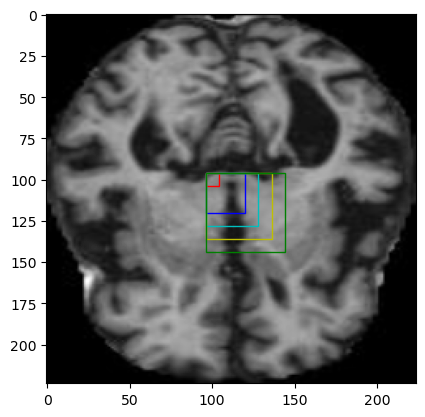

In [82]:
#visualize different cell sizes against an mri scan
import matplotlib.patches as patches

fig, ax = plt.subplots()

ax.imshow(alz_images_train[0], cmap='gray')
patch1 = patches.Rectangle((96, 96), 8, 8, linewidth=1, edgecolor='r', facecolor='none')
patch2 = patches.Rectangle((96, 96), 24, 24, linewidth=1, edgecolor='b', facecolor='none')
patch3 = patches.Rectangle((96, 96), 32, 32, linewidth=1, edgecolor='c', facecolor='none')
patch4 = patches.Rectangle((96, 96), 40, 40, linewidth=1, edgecolor='y', facecolor='none')
patch5 = patches.Rectangle((96, 96), 48, 48, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.add_patch(patch3)
ax.add_patch(patch4)
ax.add_patch(patch5)
plt.show

In [83]:
#function that extracts HOG features based on input parameters
def HOG_extractor(data=[], 
                  orientations = 15,
                  pixels_per_cell = (40,40), 
                  cells_per_block = (6,6)):
    
    hog_data = []
    for i in range (0, len(data)):
        hog_data.append(hog(data[i], orientations = orientations, 
                        pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block))
        
    
    return hog_data


In [84]:
#Evaluate whether RFC performs better with HOG feature extraction, and HOG feature extraction +equalize 


def HOG_RFC_evaluate(
    train =[], train_label= [], 
    test=[], test_label = [],
    
    #Equalization Flag
    use_Equalize = False,
    
    #HOG parameters
    orientations = [21], cellSize = [(32,32)], blockSize = [(7,7)],
    
    #RFC parameters
    n_estimators=[1000], 
    max_depth=[20],
    use_cw = False): 
    
    NumHOGParam = len(orientations)*len(cellSize)*len(blockSize)
    summary = pd.DataFrame(columns=['Equalization', 'Orientations', 'Cell Size', 'Block Size', 'Val Accuracy'])
    RFC_performance = []

    id1 = 0
    id2 = 0
    id3 = 0
    
    #Prepare Train and Test Data for HOG feature extraction
    
    images_train = np.copy(alz_images_train)
    images_test = np.copy(alz_images_test)
    
    #Equalize images first before HOG feature extraction, if flag is True
    if(use_Equalize == True):
        images_train = equalizeImage(images_train)
        images_test = equalizeImage(images_test)

        
            
    #Evaluate RFC performance per HOG hyperparameter combination    

    for i in range(0, NumHOGParam):
    
        
        HOG_train = HOG_extractor(images_train, orientations = orientations[id1],
                              pixels_per_cell = cellSize[id2],
                              cells_per_block = blockSize[id3])

        HOG_test  = HOG_extractor(images_test, orientations = orientations[id1],
                              pixels_per_cell = cellSize[id2],
                              cells_per_block = blockSize[id3])
    
    
    
        summary.at[i, 'Equalization'] = use_Equalize
        summary.at[i, 'Orientations'] = orientations[id1]
        summary.at[i, 'Cell Size'] = cellSize[id2]
        summary.at[i, 'Block Size'] = blockSize[id3]
    
        #update index
    
        if((id2 == len(np.array(cellSize))-1) & (id3 == len(np.array(blockSize)) - 1 )) : id1 = (id1 + 1)%len(np.array(orientations))
        if(id3 == len(np.array(blockSize)) - 1 ) : id2 = (id2 + 1)%len(np.array(cellSize))
        id3 = (id3 + 1)%len(np.array(blockSize)) #always increment by 1 per iteration

        #skip model fitting/evaluation if HOG doesnt return any features
        if(np.array(HOG_train[0]).shape ==(0,)): 
            RFC_performance.append([])
            continue
    
        #evaluate RFC
        performance = RFC_evaluate(train = HOG_train, train_label = alz_labels_train,
                               test = HOG_test, test_label = alz_labels_test,
                               n_estimators = n_estimators, max_depth = max_depth,
                               use_cw = use_cw)
        
        #print HOG debug
        print("i: ", i)
        print("Summary:\n", summary)
        print("RFC Performance:\n", performance)
    
        
        RFC_performance.append(performance)
    
    
    return summary, RFC_performance
    
    



In [85]:
#HOG parameters to try
orientations = [15, 21, 24] #the number of edge orientations each 'cell' is going to be converted to.
cellSize = [(32,32)] #in pixels
blockSize = [(7,7)] #in cells, used in normalization

#RFC parameters to try
n_estimators = [1500]
max_depth = [20]

#Evaluate RFC with HOG
hog_features, RFC_performance = HOG_RFC_evaluate(
    train =alz_images_train, train_label= alz_labels_test, 
    test=alz_images_test, test_label = alz_labels_test,
    
    #Equalization Flag
    use_Equalize = False,
    
    #HOG parameters
    orientations = orientations, cellSize = cellSize, blockSize = blockSize,
    
    #RFC parameters
    n_estimators=n_estimators, 
    max_depth=max_depth,
    use_cw = False)

i:  0
Summary:
   Equalization Orientations Cell Size Block Size Val Accuracy
0        False           15  (32, 32)     (7, 7)          NaN
RFC Performance:
   Estimators Max Depth   Training Time Training Accuracy Val Accuracy
0       1500        20  0:02:11.234000               1.0     0.582486
i:  1
Summary:
   Equalization Orientations Cell Size Block Size Val Accuracy
0        False           15  (32, 32)     (7, 7)          NaN
1        False           21  (32, 32)     (7, 7)          NaN
RFC Performance:
   Estimators Max Depth   Training Time Training Accuracy Val Accuracy
0       1500        20  0:02:34.250000               1.0     0.566067
i:  2
Summary:
   Equalization Orientations Cell Size Block Size Val Accuracy
0        False           15  (32, 32)     (7, 7)          NaN
1        False           21  (32, 32)     (7, 7)          NaN
2        False           24  (32, 32)     (7, 7)          NaN
RFC Performance:
   Estimators Max Depth   Training Time Training Accuracy Val

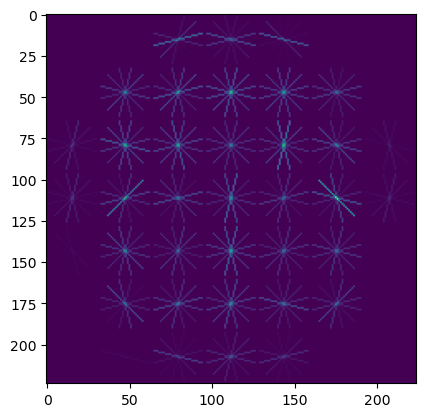

In [119]:
#HOG image visualization for alz_images_train[0]
#cell size is 32x32 pixels
#block size is 7x7 cells

In [202]:
#RNN
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

tf.random.set_seed(99)

In [203]:
#Convert labels to integer values as required by Keras 
labels_train_int = np.copy(alz_labels_train)
labels_train_int[labels_train_int=='MildDemented']=0
labels_train_int[labels_train_int=='ModerateDemented']=1
labels_train_int[labels_train_int=='NonDemented']=2
labels_train_int[labels_train_int=='VeryMildDemented']=3
labels_train_int = labels_train_int.astype(int)

labels_test_int = np.copy(alz_labels_test)
labels_test_int[labels_test_int=='MildDemented']=0
labels_test_int[labels_test_int=='ModerateDemented']=1
labels_test_int[labels_test_int=='NonDemented']=2
labels_test_int[labels_test_int=='VeryMildDemented']=3
labels_test_int = labels_test_int.astype(int)

In [204]:
#compute class_weights due to data imbalance
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(labels_train_int), 
                                     y = labels_train_int)

class_weights = dict(zip(np.unique(labels_train_int), class_weights))
class_weights

{0: 1.7855648535564854,
 1: 24.620192307692307,
 2: 0.50009765625,
 3: 0.7144252232142857}

In [205]:
# create checkpoint to save best RNN model to a file depending on "val_accuracy"
checkpoint_filepath = "./Model_Checkpoints/RNN/GRU128_Batch32_BestModel.keras"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [206]:
%%time
# Initialize/compile/train RNN Model (Keras provides three different RNN algorithms - Simple RNN, LSTM, and GRU)
# Case 1. With Class_Weight, hyperparameter is epoch

model = tf.keras.Sequential([
          tf.keras.Input(shape=(224,224)), #input image size
          tf.keras.layers.GRU(128), #GRU number of units
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')]) #number of output classes
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

#train RNN using 150 epochs, and save the best model to a file for evaluation 
trainer=model.fit(np.array(alz_images_train), np.array(labels_train_int),
                  validation_data=(np.array(alz_images_test), np.array(labels_test_int)), 
                  epochs=150,
                  class_weight = class_weights,
                  callbacks=[model_checkpoint_callback])



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 128)               135936    
                                                                 
 batch_normalization_33 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 4)                 516       
                                                                 
Total params: 136,964
Trainable params: 136,708
Non-trainable params: 256
_________________________________________________________________
Epoch 1/150
161/161 [==============================] - 23s 135ms/step - loss: 1.4315 - accuracy: 0.2835 - val_l

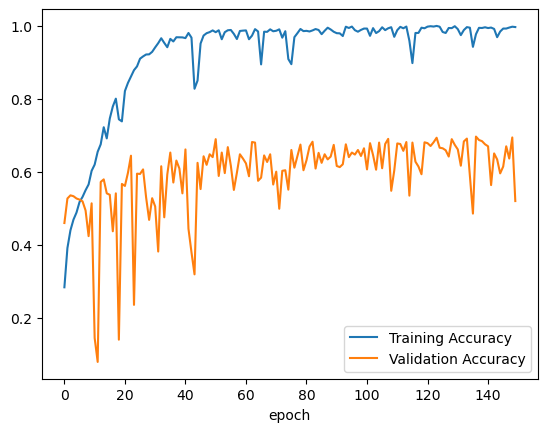

In [207]:
# Training and Validation Accuracy vs Epoch
plt.plot(trainer.history['accuracy'], label='Training Accuracy')
plt.plot(trainer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("epoch")
plt.legend()

In [208]:
#Max Accuracy
print(np.max(trainer.history['val_accuracy']))

0.6966379880905151


In [209]:
#Load Best Model and generate classification report
#model = tf.keras.saving.load_model(filepath = checkpoint_filepath)
best_model = tf.keras.Sequential([
          tf.keras.Input(shape=(224,224)), #input image size
          tf.keras.layers.GRU(128), #GRU number of units
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')]) #number of output classes
best_model.load_weights(checkpoint_filepath)

#print classification report for best model
y_pred = best_model.predict(np.array(alz_images_test))
labels_pred = np.argmax(y_pred, axis=1)
print(classification_report(labels_test_int, labels_pred))

40/40 [==============================] - 2s 49ms/step
              precision    recall  f1-score   support

           0       0.85      0.31      0.46       179
           1       1.00      0.25      0.40        12
           2       0.72      0.86      0.78       640
           3       0.64      0.63      0.63       448

    accuracy                           0.70      1279
   macro avg       0.80      0.51      0.57      1279
weighted avg       0.71      0.70      0.68      1279



In [190]:
#CASE 2. Train with NO Class Weight

#Save best model for no class_weight adjustments
checkpoint_filepath = "./Model_Checkpoints/RNN/GRU128_Batch32_BestModel_NoCW.keras"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

model2 = tf.keras.Sequential([
          tf.keras.Input(shape=(224,224)),
          tf.keras.layers.GRU(128),
          tf.keras.layers.BatchNormalization(),
          #tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')])


model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model2.summary()

trainer2=model2.fit(np.array(alz_images_train), np.array(labels_train_int),
                  validation_data=(np.array(alz_images_test), np.array(labels_test_int)), 
                  epochs=150,
                  #class_weight = class_weights1
                  callbacks=[model_checkpoint_callback])



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 128)               135936    
                                                                 
 batch_normalization_31 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 4)                 516       
                                                                 
Total params: 136,964
Trainable params: 136,708
Non-trainable params: 256
_________________________________________________________________
Epoch 1/150
161/161 [==============================] - 26s 153ms/step - loss: 1.2855 - accuracy: 0.4296 - val_l

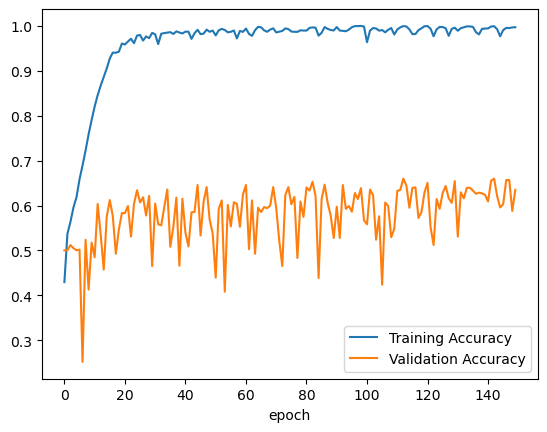

0.6598905324935913


In [191]:
# Training and Validation Accuracy vs Epoch
plt.plot(trainer2.history['accuracy'], label='Training Accuracy')
plt.plot(trainer2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

#Max Accuracy
print(np.max(trainer2.history['val_accuracy']))

In [192]:
#Load Best Model for this model variation and generate classification report
checkpoint_filepath = "./Model_Checkpoints/RNN/GRU128_Batch32_BestModel_NoCW.keras"
best_model = tf.keras.Sequential([
          tf.keras.Input(shape=(224,224)), #input image size
          tf.keras.layers.GRU(128), #GRU number of units
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(4, activation='softmax')]) #number of output classes
best_model.load_weights(checkpoint_filepath)

#print classification report for best model
y_pred = best_model.predict(np.array(alz_images_test))
labels_pred = np.argmax(y_pred, axis=1)
print(classification_report(labels_test_int, labels_pred))

40/40 [==============================] - 2s 51ms/step
              precision    recall  f1-score   support

           0       0.63      0.31      0.42       179
           1       0.75      0.25      0.38        12
           2       0.68      0.87      0.77       640
           3       0.61      0.51      0.56       448

    accuracy                           0.66      1279
   macro avg       0.67      0.49      0.53      1279
weighted avg       0.65      0.66      0.64      1279



In [193]:
report_dict_rnn = classification_report(labels_test_int, labels_pred, output_dict=True)
print(report_dict_rnn)

rnn_dict = {
    "accuracy": report_dict_rnn["accuracy"],
    "MildDemented": {
        "precision": report_dict_rnn["0"]["precision"],
        "recall": report_dict_rnn["0"]["recall"],
        "f1-score": report_dict_rnn["0"]["f1-score"]
    },                          
    "ModerateDemented": {
        "precision": report_dict_rnn["1"]["precision"],
        "recall": report_dict_rnn["1"]["recall"],
        "f1-score": report_dict_rnn["1"]["f1-score"]
    },
    "NonDemented": {
        "precision": report_dict_rnn["2"]["precision"],
        "recall": report_dict_rnn["2"]["recall"],
        "f1-score": report_dict_rnn["2"]["f1-score"]
    },
    "VeryMildDemented": {
        "precision": report_dict_rnn["3"]["precision"],
        "recall": report_dict_rnn["3"]["recall"],
        "f1-score": report_dict_rnn["3"]["f1-score"]
    }
}

print(rnn_dict)

{'0': {'precision': 0.6292134831460674, 'recall': 0.3128491620111732, 'f1-score': 0.41791044776119407, 'support': 179}, '1': {'precision': 0.75, 'recall': 0.25, 'f1-score': 0.375, 'support': 12}, '2': {'precision': 0.6838868388683886, 'recall': 0.86875, 'f1-score': 0.7653131452167928, 'support': 640}, '3': {'precision': 0.613941018766756, 'recall': 0.5111607142857143, 'f1-score': 0.5578562728380024, 'support': 448}, 'accuracy': 0.6598905394839718, 'macro avg': {'precision': 0.669260335195303, 'recall': 0.4856899690742219, 'f1-score': 0.5290199664539974, 'support': 1279}, 'weighted avg': {'precision': 0.6523552515765609, 'recall': 0.6598905394839718, 'f1-score': 0.640364341922929, 'support': 1279}}
{'accuracy': 0.6598905394839718, 'MildDemented': {'precision': 0.6292134831460674, 'recall': 0.3128491620111732, 'f1-score': 0.41791044776119407}, 'ModerateDemented': {'precision': 0.75, 'recall': 0.25, 'f1-score': 0.375}, 'NonDemented': {'precision': 0.6838868388683886, 'recall': 0.86875, 'f

<h1>Comparison</h1>

In [ ]:
# rnn_dict
# rfc_dict
# svm_dict # need to change the hot encoded back to category
# knn_dict
# cnn_graph_dict
# dnn_dict
# cnn_dict # need to change the hot encoded back to category



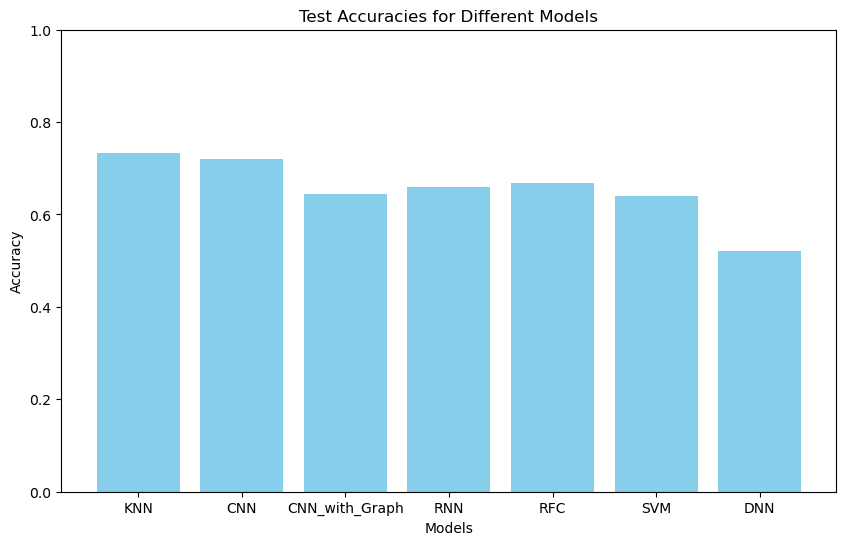

In [194]:
import matplotlib.pyplot as plt

def plot_accuracies(*metric_dicts):
    models = ["KNN", "CNN", "CNN_with_Graph", "RNN", "RFC", "SVM", "DNN"]
    accuracies = [metric_dict["accuracy"] for metric_dict in metric_dicts]
    
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color='skyblue')
    plt.title('Test Accuracies for Different Models')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1 for consistency
    plt.show()

# Example usage:
plot_accuracies(knn_dict, cnn_dict, cnn_graph_dict, rnn_dict, rfc_dict, svm_dict, dnn_dict)





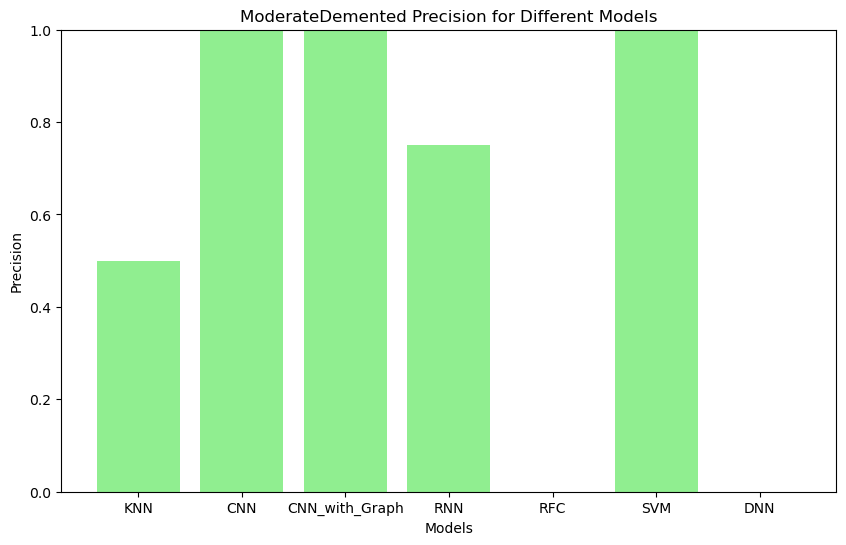

In [195]:
import matplotlib.pyplot as plt

def plot_precision_moderate_demented(*metric_dicts):
    models = ["KNN", "CNN", "CNN_with_Graph", "RNN", "RFC", "SVM", "DNN"]
    precisions = [metric_dict["ModerateDemented"]["precision"] for metric_dict in metric_dicts]
    
    plt.figure(figsize=(10, 6))
    plt.bar(models, precisions, color='lightgreen')
    plt.title('ModerateDemented Precision for Different Models')
    plt.xlabel('Models')
    plt.ylabel('Precision')
    plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1 for consistency
    plt.show()

# Example usage:
plot_precision_moderate_demented(knn_dict, cnn_dict, cnn_graph_dict, rnn_dict, rfc_dict, svm_dict, dnn_dict)


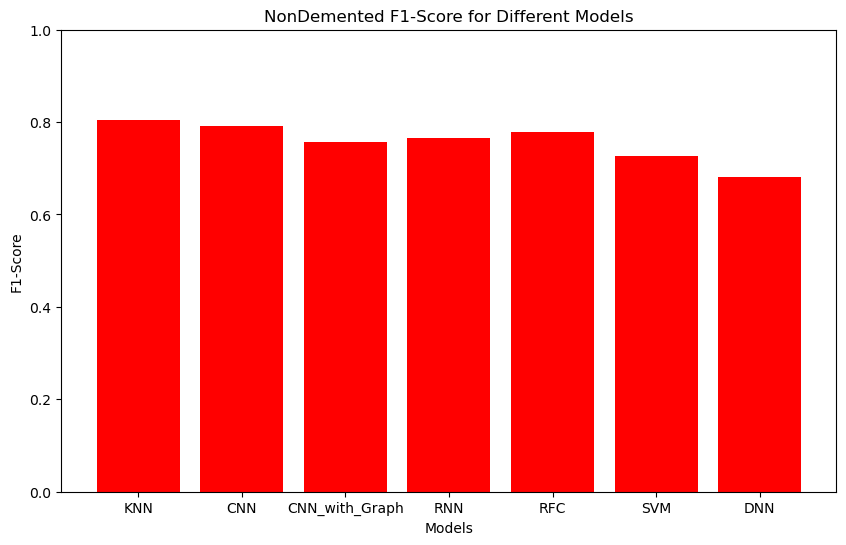

In [200]:
import matplotlib.pyplot as plt

def plot_f1_score_nondemented(*metric_dicts):
    models = ["KNN", "CNN", "CNN_with_Graph", "RNN", "RFC", "SVM", "DNN"]
    f1_scores = [metric_dict["NonDemented"]["f1-score"] for metric_dict in metric_dicts]
    
    plt.figure(figsize=(10, 6))
    plt.bar(models, f1_scores, color='red')
    plt.title('NonDemented F1-Score for Different Models')
    plt.xlabel('Models')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1 for consistency
    plt.show()

# Example usage:
plot_f1_score_nondemented(knn_dict, cnn_dict, cnn_graph_dict, rnn_dict, rfc_dict, svm_dict, dnn_dict)


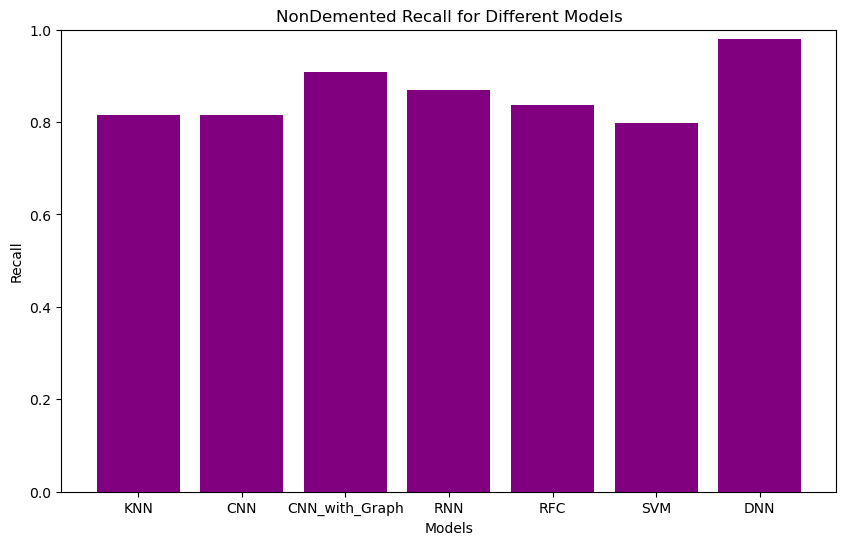

In [201]:
import matplotlib.pyplot as plt

def plot_recall_non_demented(*metric_dicts):
    models = ["KNN", "CNN", "CNN_with_Graph", "RNN", "RFC", "SVM", "DNN"]
    recalls = [metric_dict["NonDemented"]["recall"] for metric_dict in metric_dicts]
    
    plt.figure(figsize=(10, 6))
    plt.bar(models, recalls, color='purple')
    plt.title('NonDemented Recall for Different Models')
    plt.xlabel('Models')
    plt.ylabel('Recall')
    plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1 for consistency
    plt.show()

# Example usage:
plot_recall_non_demented(knn_dict, cnn_dict, cnn_graph_dict, rnn_dict, rfc_dict, svm_dict, dnn_dict)
